table flowReadings deleted


<IPython.core.display.Javascript object>


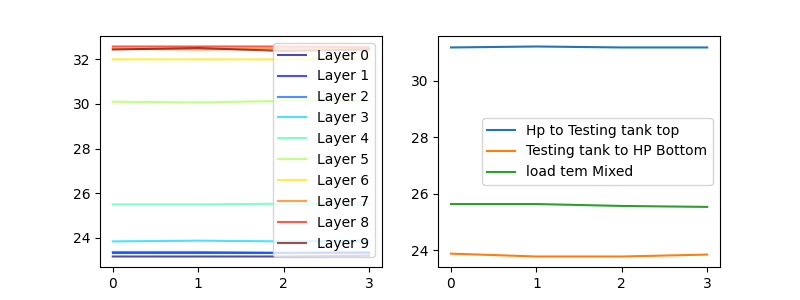

<IPython.core.display.Javascript object>


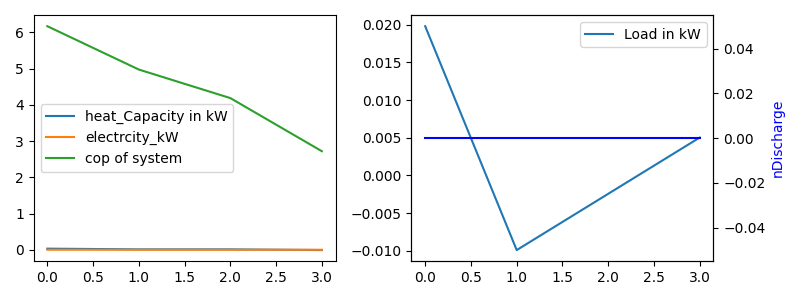

<IPython.core.display.Javascript object>


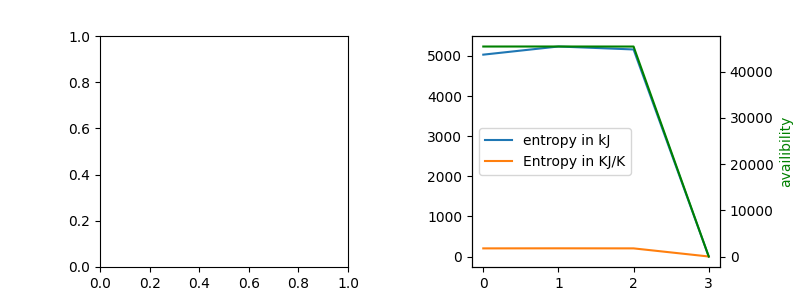

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((5219, datetime.datetime(2021, 3, 31, 14, 54, 41), 24.2122, 31.186, 23.8741, 16.2406, 22.3866, 31.8638, 25.6329, 11.4532, 23.6036, 25.4976, 23.8403, 23.3669, 23.3331, 23.164, 32.4401, 32.5757, 32.474, 31.9994, 30.1018),)
electricity in khW is: 3.21455e-06
cop is: 6.173063375383394
Load in kWh is: 1.0993396122482748e-05
heat addition in kwh is: 1.984362087333869e-05
chanrging : whole kJ list is mul by 3600: 0    0.070732
dtype: float64
Availability :Total energy of in Kj is : 45411.143515888376
Charging stratified Efficiency: 0   -71144.077372
dtype: float64
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((5222, datetime.datetime(2021,

KeyboardInterrupt: 

In [18]:
import time
import board
import busio
import pandas as pd
from pandas import DataFrame
from matplotlib import pylab
import matplotlib.pyplot as plt
from pylab import *
import pylab
import numpy as np
import matplotlib.colors as clrs
import matplotlib.cm as cm
import matplotlib
from collections import deque
import os.path
import datetime
import time
import math
import struct
from struct import *
from pyModbusTCP.client import ModbusClient

#matplotlib.use('TkAgg')
%matplotlib notebook
#%matplotlib inline


#import time
import sys
import sqlite3
#from time import sleep

#import adafruit_ads1x15.ads1015 as ADS
import adafruit_ads1x15.ads1115 as ADS
from adafruit_ads1x15.analog_in import AnalogIn

import MySQLdb as db

HOST = "10.208.8.122"
PORT = 3306
USER = "yogi"
PASSWORD = "bittoo"
DB = "TemaccessToRemoteRp2"
'''
try:
    connection = db.Connection(host=HOST, port=PORT,
                               user=USER, passwd=PASSWORD, db=DB)

    c = connection.cursor()
    c.execute("SELECT * from temSensor")
    result = c.fetchall()
    for item in result:
        print (item)

except Exception as e:
    print (e)
'''
connectionL = db.connect(host="10.208.8.121",
                     user="yogi",
                     passwd="bittoo",
                     db="allSensors")

#c = conn.cursor()
connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)

cR = connectionR.cursor()
cL =connectionL.cursor()

i2c = busio.I2C(board.SCL, board.SDA)

# Create the ADC object using the I2C bus
ads = ADS.ADS1115(i2c)

ads.gain = 1


cL.execute('DROP TABLE IF EXISTS flowReadings;')
print ('table flowReadings deleted')


cL.execute('CREATE TABLE flowReadings(id INT AUTO_INCREMENT PRIMARY KEY,  \
ts TIMESTAMP DEFAULT CURRENT_TIMESTAMP, \
flowHP FLOAT, flowLoad FLOAT, watt FLOAT) ENGINE=MyISAM;')

#cvsFileName = import os.path
#os.path.exists(file_path)

lol=[[], [], [], [], []]
flowRateLoad  = []
wattMeterKw = []
################################
##Cop functions, takes Tiem stamp of both Wattmegter and Tem values
###
###############################
def flatten_watt(l_of_l):
    '''this to flatten the watt tuple/list  whish is 
    present in lol[1]
    '''
    T = l_of_l[1]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l


timePeriod_watt = []
def timeStampCreator_watt(Lol):
    '''calculating timestamp of wattmeter'''
    mHP = Lol[2]
    T = flatten_watt(Lol)
    if len(mHP) == 1:
        timeStamp = 2/3600
        timePeriod_watt.append(timeStamp)
    elif len(mHP) > 1:
        timeLast = T[-1][1]
        timeSecondLast = T[-2][1]
        timeStamp = timeLast -timeSecondLast
        timeStamp = timeStamp.total_seconds()/3600
        timePeriod_watt.append(timeStamp)
    return 

def flatten_tem(l_of_l):
    '''flatting the time lol to calculate time stamp b/w each'''
    T = l_of_l[0]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l

timePeriod_tem = []
def timeStampCreator_cop(Lol):
    '''calculatng tem time stamp to calculate accuractly the mCT '''
    mHP = Lol[2]
    T = flatten_tem(Lol)
    if len(mHP) == 1:
        timeStamp = 2/3600
        timePeriod_tem.append(timeStamp)
    elif len(mHP) > 1:
        timeLast = T[-1][1]
        timeSecondLast = T[-2][1]
        timeStamp = timeLast -timeSecondLast
        timeStamp = timeStamp.total_seconds()/3600
        timePeriod_tem.append(timeStamp)
    return 

copPlotterList = []
def Cop(Lol, time_stamp_tem, time_stamp_watt):
    '''this function takes both time stamp Tem and Watt
     because both Tem and watt are running at different timetamps
    '''
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    watt_kW = Lol[4]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    #electricty consumed:
    watt_kW_l = [x*y for x,y in zip (time_stamp_watt,  watt_kW)]
    watt_kWh = sum(watt_kW_l)
    #cop 
    cop =mCT_kWh/watt_kWh
    copPlotterList.append(cop)
    #print ('cop of system is:', cop)
    #print ('kwh heat addition is :', mCT_kWh)
    #print ('whole kW list is:', mCT_kW)
    print ('electricity in khW is:', watt_kWh)
    
    #print ('electricity consumption kW :', watt_kW)
    return cop
############################################################

def MCT_timeStamp(Lol, time_stamp_tem):
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    watt_kW = Lol[4]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    print ('heat addition in kwh is:', mCT_kWh)
    return mCT_kW

l_id = []
def idGenerator(Id, l_id):
    if Id not in l_id:
       l_id.append(Id) 
    #print (l_id)
    return l_id

#df_conc= None
def dfs(Lol):
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    StartTemTestingtank = [ 'id', 'dateTime', 'Tamb', 'TtopTestTankHPCir', 'TbottomTestTankHpCir', 'TtopSourceTank', \
'TloadTankMix','TTopTestTankLoadCir', 'TloadMix', 'TbottomSourceTank', 'TbottomTestTankLoadCir']
    l_T = ['T{}'.format(x) for x in range(0,10)]
    L = StartTemTestingtank +l_T
    df_mHP = DataFrame(mHP, columns=['flowHP'])
    df_mL = DataFrame(mL, columns=['flowLoad'])
    df_tem = DataFrame(T, columns = L)
    df_conc = pd.concat([df_tem, df_mHP, df_mL], axis=1)
    return df_conc

def list2df(lis, column_name = None):
    df  = pd.DataFrame(lis, columns = [column_name]) 
    return df


def toCsv(df_full, load_kW, heatCapacity_kW, electrictyUsed_kW, COP, nDis, timePeriod, \
         entropy_kjPerK, entropy_kJ, nStratCharging, TankEnergyTotal_kJ):
    df_Tem_Flow_Load_capacity_conc = pd.concat([df_full, load_kW, heatCapacity_kW, electrictyUsed_kW, \
                                                COP, nDis, timePeriod, entropy_kjPerK,\
                                               entropy_kJ,nStratCharging, \
                                               TankEnergyTotal_kJ], axis=1)
    #df_Tem_Flow_Load_capacity_conc = df_Tem_Flow_Load_capacity_conc.replace(',',np.nan)
    #import os.path
    #import datetime
    file_name = 'csvFile_{}'.format(datetime.datetime.now().strftime("%Y_%m_%d"))
    suffix = '.csv'
    filePath = os.path.join(os.getcwd(), file_name + suffix)
    #df_Tem_Flow_Load_capacity_conc.to_csv(filePath, header=True, na_rep=np.nan)
    #print ('gross df with NAN is: ', df_Tem_Flow_Load_capacity_conc )
    return df_Tem_Flow_Load_capacity_conc

def Load_kWh(Lol, time_stamp_tem):
    
    #mHP = Lol[2]
    T = flatten_tem(Lol)
    #d = [x[10] for x in T]
    #print ('XXXXTem tem diagnosis is :', d)
    mL = Lol[3]
    #this is density as polynomial function of T
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[7] - 8.42930922e-03*x[7]**2 + 6.77190849e-05*x[7]**3 \
 - 4.40840180e-07*x[7]**4 + 1.29302849e-09*x[7]**5 for x in T]
    #print ('denisty is:', p_LperH )
    #print ('Tem is:', [x[10] for x in T])
    # this is mass flow  in kg/S =  density*V(flow rate in m^3/sec)= d * (1000^-3/3600)
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mL)]
    #this is Cp as functiono of T linear function
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[7] for b in T]
    #print ('Cp if load function is:')
    #print ('Cp is:', cP_kjPerkgK)
    #Cp*M*deltaT
    load_mCT_kW = [c*a*(b[7]-b[10]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    load_mCT_kW_l = [x*y for x,y in zip (time_stamp_tem, load_mCT_kW )]
    load_mCT_kWh = sum(load_mCT_kW_l)
    print ('Load in kWh is:', load_mCT_kWh)
    #print ('Load in kW:', load_mCT_kW)
    return load_mCT_kW

def tankStrat(df):
    dfT = df.iloc[:, 11:-2]
    #print (dfT.columns)
    #print (dfT)
    dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T9', 'T8', 'T7', 'T6', 'T5']]
    dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T9':'T5', 'T8':'T6',\
              'T7':'T7','T6':'T8','T5':'T9'}, axis='columns')

    return dfT
#tankStratTem = tankStrat(df_conc)

def create_color_step_obj(cmap_name, n):
    """
    Return scalarMap object with n colors in gradient from color map
    given in cmap_name.
    """
    cmap = plt.get_cmap(cmap_name)
    values = range(n)
    cNorm  = clrs.Normalize(vmin=values[0], vmax=values[-1])
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    return scalarMap

#import logging
#logging.getLogger().setLevel(logging.CRITICAL)

# colors
cmap_name = "jet"
scm = create_color_step_obj(cmap_name, 10)

plt.ion()
#plt.rcParams["figure.figsize"]=5,5
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 3
def plotObject(df, ax, fig, alpha =0.7, scm=None):
    ax.clear()
    for i in range (0, df.shape[1]):
        ax.plot(df.index, df.iloc[:, i], color= scm.to_rgba(i, alpha=alpha),\
                label = 'Layer ' + str(i))
        ax.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax.legend()
    #plt.legend(loc='upper left')
    return fig, ax
    
# initialize figure and interactivity
fig = plt.figure(1)
fig2 = plt.figure(2)
fig3 = plt.figure(3)


ax = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
ax2 = fig2.add_subplot(122)
ax2_1 = fig2.add_subplot(121)
axTwin = ax2.twinx()

ax3 = fig3.add_subplot(122)
ax3_1 = fig3.add_subplot(121)
ax3Twin = ax3.twinx()
fig.canvas.draw()
#plt.ion()

fig.show()

ax.legend(loc='best')
ax.set_xlabel('Index')
ax.set_ylabel('Tem, C', color='r')
#################################
#Plot for HPin, Hpout, TmixL tem.

fig.show()
fig.canvas.draw()
ax_2.legend(loc='best')
ax_2.set_xlabel('Index')
ax_2.set_ylabel('Load in kW', color='r')
def plotObject_Tem_HpAndLoad(df, ax_2, fig):
    ax_2.clear()
    ax_2.plot(df.index, df.iloc[:, 3], label = 'Hp to Testing tank top')
    ax_2.plot(df.index, df.iloc[:, 4], label = 'Testing tank to HP Bottom')
    ax_2.plot(df.index, df.iloc[:, 8], label = 'load tem Mixed')
    
    ax_2.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax_2.legend()
    fig.savefig('Temperatures3.png')
    #plt.legend(loc='upper left')
    return fig, ax_2
##################################

#fig2 = plt.figure(2)

#plt.ion()

fig2.show()
fig2.canvas.draw()
ax2.legend(loc='best')
ax2.set_xlabel('Index')
ax2.set_ylabel('Load in kW', color='r')
def plotObject_Load(df, ax2, fig2):
    ax2.clear()
    axTwin.clear()
    ax2.plot(df.index, df.iloc[:, -10],label = 'Load in kW')
    axTwin.plot(df.index, Nan2Zero(df).iloc[:, -6]*100, label = 'Discharge Efficiency', color = 'b')
    axTwin.set_ylabel('nDischarge',color ='b')
    #ax2.plot(df.index, COP, label = 'cop')
    #print (df.index)
    ax2.legend(bbox_to_anchor=(0.4,0.8))
    fig2.canvas.draw()
    ax2.legend()
    #plt.legend(loc='upper left')
    return fig2, ax2
    
# initialize figure and interactivity
####Plot for heat_Capacity:

def Nan2Zero(df):
    #df.replace('NaN', 0)
     return df.fillna(0) 

fig2.show()
fig2.canvas.draw()
ax2_1.legend(loc='best')
ax2_1.set_xlabel('Index')
ax2_1.set_ylabel('Heat_Capacity in kW', color='r')
def plotObject_Heat_Capacity(df, ax2_1, fig2):
    ax2_1.clear()
    #axTwin = ax2_1.twinx()
    #axTwin.clear()
    
    ax2_1.plot(df.index, df.iloc[:, -9], label = 'heat_Capacity in kW')
    ax2_1.plot(df.index, df.iloc[:, -8], label = 'electrcity_kW')
    ax2_1.plot(df.index, df.iloc[:, -7], label = 'cop of system')
    #axTwin.plot(df.index, Nan2Zero(df).iloc[:, -2]*100, label = 'Discharge Efficiency', color = 'b')
    #axTwin.set_ylabel('nDischarge',color ='b')
    
    ax2_1.legend(bbox_to_anchor=(0.4,0.8))
    plt.subplots_adjust(wspace = 0.5)
    fig2.canvas.draw()
    ax2_1.legend()
    fig2.tight_layout()
    #plt.legend(loc='upper left')
    return fig2, ax2_1

############################
##Exergy/Entropy/nStrt plots
#############################

fig3.show()
fig3.canvas.draw()
ax3.legend(loc='best')
ax3.set_xlabel('Index')
ax3.set_ylabel('Entropy_kJ', color='r')
def plotObject_entropy(df, ax3, fig3):
    ax3.clear()
    ax3Twin.clear()
    y1 = Nan2Zero(df.iloc[:, -3])
    y2= Nan2Zero(df.iloc[:, -4])
    y3 = Nan2Zero(df.iloc[:, -1])
    #ax3.plot(df.index, y1, label = 'entropy in kJ')
    ax3.plot(df.index, y1, label = 'entropy in kJ')
    ax3.plot(df.index, y2, label = 'Entropy in KJ/K')
    #ax3.plot(df.index, y3, label = 'Availability kJ')
    ax3Twin.plot(df.index, y3, label = 'Availability kJ', color = 'g')
    #ax3.plot(df.index, df.iloc[:, 8], label = 'load tem Mixed')
    ax3Twin.set_ylabel('availibility',color ='g')

    ax3.legend(bbox_to_anchor=(0.4,0.8))
    fig3.canvas.draw()
    ax3.legend()
    #plt.legend(loc='upper left')
    return fig3, ax3


#######################
###Discharge efficiency
#######################
def densityFumction(temVlaue):
    #tcalculating density at a specific temp.
    return temVlaue.map(lambda x: 999.8473664794213 + 6.29265190e-02*x - \
    8.42930922e-03*x**2 + 6.77190849e-05*x*3 \
    - 4.40840180e-07*x**4 + 1.29302849e-09*x**5)

def flowCubeMeterPerSec(flow):
    return flow.map(lambda x: x*0.001*0.000277777778)

def specificHeatkJPerKgK(temValue):
    return temValue.map(lambda x: 4.253264761904763 - 0.00470305*x)

def dfMultiplication(df1_p_hot, cp_df_hot, df1_p_cold, cp_df_cold, df_V,  Tin, Tout, timeStamp_tem):
    
    #df_V_litersPerH =  df_V.map(lambda x: x*1000*3600)
    #if df_V_litersPerH.iloc[-1] > 5:
    
    #Hot side p*V*Cp*T_hot in kj/sec, I will convert it to kwh by multiplying by timeStamp.Then to KJ
    #Finally because I need to divide teh net energy extraccted by total energy mstore*C*dT which is 
    #in kJ.
    #deltaT_df = Tout.subtract(Tin)
    l2df_timeStamp_df= pd.DataFrame(timeStamp_tem)
    #print ('type of timestamp object is:', type (l2df_timeStamp_df))
    pcp_df_hot = df1_p_hot.multiply( cp_df_hot)
    pVCp_df_hot = pcp_df_hot.multiply(df_V)
    pCpVT_df_hot = pVCp_df_hot.multiply(Tout)
    
    #Cold side pCpVT_df_cold is in kJ/s:
    # I am seperating hot from cold becasue density, Cp are funstion of temp.otherwise I would have
    # only done pVCp [Thot -Tcold] without any problem, however, p&Cp are function of Thot and Tcold
    #So I calculate them during hot and during cold side and just subtract them
    pcp_df_cold = df1_p_cold.multiply(cp_df_cold)
    pVCp_df_cold = pcp_df_cold.multiply(df_V)
    pCpVT_df_cold = pVCp_df_cold.multiply(Tin)
    
    pVCpDeltaT_df_kJPersec = pCpVT_df_hot.subtract( pCpVT_df_cold )
    #convert pandas series to pandas dataframe.otherwise it will not multiply with other PD series in
    #next step:
    pVCpDeltaT_df_kJPersec = pVCpDeltaT_df_kJPersec.to_frame()
    #print ('type of timestamp object is:', type (pVCpDeltaT_df_kJPersec))
    # convert the kJ/sec to kwH, as energy = power in time, 
    pVCpDeltaT_df_kWh = pVCpDeltaT_df_kJPersec.multiply(l2df_timeStamp_df, fill_value=0)
    #pVCpDeltaT_sum  = pVCpDeltaT_df.sum()
    pVCpDeltaT_df_kWh_sum  = pVCpDeltaT_df_kWh.sum()
    #convert kwh to kJ as I need to divide mstore * C *DeltaT = kJ to calculate teh discharge
    #efficiency, so energy taken out must be in kJ instead of kwh. To make sense 
    pVCpDeltaT_df_kJ_sum = pVCpDeltaT_df_kWh_sum*3600
    pVCpDeltaT_df_kJ_sum  = pd.to_numeric(pVCpDeltaT_df_kJ_sum)
    #print ('flow lools like this:',df_V)
    print ('Total sum discharge in kJ is :',pVCpDeltaT_df_kJ_sum )
    #print ('discharge in kJ/sec:',pVCpDeltaT_df_kJPersec ,'tiem df is',  l2df_timeStamp_df\
    #       , 'multiplied df is:', pVCpDeltaT_df_kWh)
    #print ('multiplied df is :', )
    #pVCpDeltaT = pVCp.multiply(deltaT_df)
    return pVCpDeltaT_df_kJ_sum

def TankVolumeDischarged(Lol,timeStamp):
    mLoad = Lol[3]
    #print ('len of Mload is:', len (mLoad))
    #print ('len of tiem stamp is:', len (timeStamp))
    litersDischarged = sum([x*y for x, y in zip (mLoad , timeStamp)])
    print ('liters discharged is :',litersDischarged )
    return litersDischarged

nDischargePlotterList = []
def nDicharge(df_conc_all, gross_DF):
    '''
    T_initial should be average tem of tank i.e. mean of 10 sensors just before the discharge
    initiates 

    '''
    df_flowGreaterThan5 = df_conc_all.loc[(df_conc_all['flowLoad']>0.5)&(df_conc_all['flowLoad']<5)]
    #print ('df for just before discharge starts is:', df_flowGreaterThan5['flowLoad'], df_flowGreaterThan5['id'] )
    df_flowGreaterThan5_temValues = df_flowGreaterThan5.iloc[-1, -12:-2]
    print ('df for just before discharge starts is:', df_flowGreaterThan5_temValues, df_flowGreaterThan5.iloc[-1]['id'] )
    df_flowGreaterThan5_mean  = df_flowGreaterThan5_temValues.mean()
    T_inlet = df_conc_all['TbottomTestTankLoadCir']
    T_inlet_lastValue  =  T_inlet.iloc[-1]
    cP_kjPerkgK = 4.253264761904763 - 0.00470305*df_flowGreaterThan5_mean 
    p_LperH = 999.8473664794213 + 6.29265190e-02*df_flowGreaterThan5_mean - \
    8.42930922e-03*df_flowGreaterThan5_mean**2 + 6.77190849e-05*df_flowGreaterThan5_mean**3 \
 - 4.40840180e-07*df_flowGreaterThan5_mean**4 + 1.29302849e-09*df_flowGreaterThan5_mean**5 
    
    mcT_kJ = 0.397*p_LperH*cP_kjPerkgK*(df_flowGreaterThan5_mean-T_inlet_lastValue)
    #mcT_kJ shoudl be constant throught the discharge process, as its the energy content of tank 
    #from very begineening of tank.
    flowLoad  = df_conc_all['flowLoad']
    T_out  = df_conc_all['TTopTestTankLoadCir']
    #T_inlet = df_conc_all['TbottomTestTankLoadCir']
    if not abs(T_out.iloc[-1]-T_inlet.iloc[-1]) <  0.8*abs(df_flowGreaterThan5_mean-T_inlet.iloc[-1]):
        print ('OK ok oK oK ok if not small run ')
        '''
        flowLoad  = df_conc_all['flowLoad']
        waterDensityAtInletTem_df_series = densityFumction(T_inlet)
        flow_kgPerS = flowCubeMeterPerSec(flowLoad)*waterDensityAtInletTem_df_series
        T_out  = df_conc_all['TTopTestTankLoadCir']
        T_inlet = df_conc_all['TbottomTestTankLoadCir']
        mcT_sum = flowLoad
        '''
        
        numerator = dfMultiplication(densityFumction(gross_DF['TTopTestTankLoadCir']), \
                         specificHeatkJPerKgK(gross_DF['TTopTestTankLoadCir']), \
                         densityFumction(gross_DF['TbottomTestTankLoadCir']),\
                         specificHeatkJPerKgK(gross_DF['TbottomTestTankLoadCir']),\
                         flowCubeMeterPerSec(gross_DF ['flowLoad']), \
                         gross_DF['TbottomTestTankLoadCir'], \
                         gross_DF['TTopTestTankLoadCir'], timePeriod_tem)
        denominator = mcT_kJ
        dischargeEfficiency =  numerator/denominator
        dischargeEfficiency= dischargeEfficiency.to_numpy()[0]
        print('type of nDis now is ', dischargeEfficiency)
        #dischargeEfficiency = pd.to_numeric(dischargeEfficiency)
        nDischargePlotterList.append(dischargeEfficiency)
        print ('energy content of tank from the begineening of discharge in kJ, Inlet, mean, cp, p:' \
               , denominator, T_inlet_lastValue, df_flowGreaterThan5_mean, cP_kjPerkgK,p_LperH )
        #print ('energy content of tank from the begineening of discharge in kJ:', denominator)
        print ('energy/sec discharged from tank in kJ/sec:', numerator)
        print ('discharge efficiency is:', dischargeEfficiency)

        return dischargeEfficiency
        
    '''
    #print ('mean of the T_initial  and index is :', df_flowGreaterThan5.iloc[-1][['id']], df_flowGreaterThan5_mean)
    #print ('mean of the T_initial  and index is :', df_flowGreaterThan5.iloc[-1][['id']], df_flowGreaterThan5_mean)
    print('heat capacity of water mixed is:',cP_kjPerkgK )
    print ('condition check Tout-T_in:', T_out.iloc[-1]-T_inlet.iloc[-1])
    print ('80% condition check :', 0.8*abs(df_flowGreaterThan5_mean-T_inlet.iloc[-1]))
    #print ('Inlet and mean to teh tank and mct and density is :', T_inlet_lastValue, df_flowGreaterThan5_mean,  mcT_kJ, p_LperH)
    #if df_flowGreaterThan5
    #.iloc[-12:-3]
    #T_initial = df__conc_all.iloc[-1, 0:11].mean()
    return df_flowGreaterThan5_temValues
    '''

    
#####################################
####Exergy calculation for discharge#
#####################################
def mcTForExergyDischarging (l_load_kwh, time_stamp_tem):
    load_mCT_kW_l = [x*y for x,y in zip (l_load_kwh, time_stamp_tem )]
    load_kwh_total = sum(load_mCT_kW_l)
    load_kJ_total = load_kwh_total*3600
    print ('Discharging: load_kJ_total mul 3600:',load_kJ_total)
    return load_kJ_total

def entropyDischarging(Df_conc):

    mL =Df_conc['flowLoad']
    T =Df_conc.iloc[: ,11:-2]
    T_Load_out_df =  Df_conc['TTopTestTankLoadCir']
    T_Load_in_df =  Df_conc['TbottomTestTankLoadCir']
    T = T[['T4', 'T3', 'T2', 'T1', 'T0', 'T9', 'T8', 'T7', 'T6', 'T5']]
    T = T.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T9':'T5', 'T8':'T6',\
              'T7':'T7','T6':'T8','T5':'T9'}, axis='columns')
    df_density_columns = ['d{}'.format(x) for x in range(0,10)]
    df_density = T.apply(lambda x: 999.8473664794213 + 6.29265190e-02*x - \
                         8.42930922e-03*x**2 + 6.77190849e-05*x**3 \
                         - 4.40840180e-07*x**4 + 1.29302849e-09*x**5)
    #0.397/10 is probably mass of each layer which are 10 layers
    df_m_kg = df_density.multiply(0.397/10, axis =1) 
    df_heatCapacity_kJPerkgK = T.apply(lambda x: 4.253264761904763 - 0.00470305*x)
    #T0_ambient_df =pd.DataFrame([np.random.uniform(24, 26) for _ in range(T.shape[0])])
    T0_ambient_df = np.random.uniform(24, 26)
    #log [TinLoad/Ti(h)], Ti is the tanks stratified temperatures in height 
    #df_Logvalues = T.apply(lambda x: np.log(T_Load_in_df /x))
    #df_Logvalues = T.apply(lambda x: np.log(x/T_Load_in_df ))
    df_Logvalues = T.apply(lambda x: np.log(T_Load_out_df/x))
    #cpxLog[Tinlet/Ti]
    lnT_Mul_Cp_df = df_Logvalues.multiply(df_heatCapacity_kJPerkgK, axis =1)
    #mcpln[Tinlet/Ti]
    mass_mul_lnT_and_cp_df = lnT_Mul_Cp_df.multiply(df_m_kg, axis =1)
    #Tambient*DeltaS
    entropy_df = mass_mul_lnT_and_cp_df.multiply(T0_ambient_df, axis =0)
    #entropy sum for all teh columns, This si not time wise, so each tiem has one single value of tank
    entropy_sum_heightWise = entropy_df.sum(axis = 1)
    print ('discharge: log values that shoudl be negative is:', df_Logvalues)
    print ('discharge: entropy df is :', entropy_df)
    print ('discharge: entropy_sum :', entropy_sum_heightWise)
    return entropy_sum_heightWise

def StratEffDischarge(load_kJ_total_float, entropy_sum_height_float):
    
    n = (load_kJ_total_float-entropy_sum_height_float)/ load_kJ_total_float
    print ('Discharge: strat efficiency is :', n)
    return n


###################################
###Exergy calculation for charging
###################################
def mcTForExergyCharging(Lol, time_stamp_tem, time_stamp_watt):
    #this calculates the energy addiction per timestamp in the tank. and integrates it over whole charging
    
    mHP = Lol[2]
    T = flatten_tem(Lol)
    #mL = Lol[3]
    #watt_kW = Lol[4]
    #p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
    #- 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[3] - 8.42930922e-03*x[3]**2 + 6.77190849e-05*x[3]**3 \
 - 4.40840180e-07*x[3]**4 + 1.29302849e-09*x[3]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    #cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[3] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    #mCT_kJ_l = pd.DataFrame(mCT_kWh_l).multiply(3600)
    mCT_kJ_l = pd.DataFrame(mCT_kWh_l)
    #mCT_kWh_total = sum(mCT_kWh_l)
    mCT_kWh_total = mCT_kJ_l.sum()
    mCT_KJ_total = mCT_kWh_total*3600
    #electricty consumed:
    #watt_kW_l = [x*y for x,y in zip (time_stamp_watt,  watt_kW)]
    #watt_kWh = sum(watt_kW_l)
    #cop 
    #cop =mCT_kWh/watt_kWh
    #copPlotterList.append(cop)
    #print ('cop of system is:', cop)
    #print ('kwh heat addition is :', mCT_kWh)
    print ('chanrging : whole kJ list is mul by 3600:', mCT_KJ_total)
    #print ('chanrging : df of mcT energy addition is:', mCT_kJ_l)
    #print ('electricity in khW is:', watt_kWh)
    
    #print ('electricity consumption kW :', watt_kW)
    return mCT_KJ_total

entropyPlotter_SUMList_KjPerK = []
entropyPlotter_SUMList_Kj = []
MCTPlotterList_TankEnergyKJ = []
def entropyCharging(Df_conc):
    mHP =Df_conc['flowHP']
    T =Df_conc.iloc[: ,11:-2]
    T_hp_out_df =  Df_conc['TtopTestTankHPCir']
    T_hp_in_df =  Df_conc['TbottomTestTankHpCir']
    T = T[['T4', 'T3', 'T2', 'T1', 'T0', 'T9', 'T8', 'T7', 'T6', 'T5']]
    T = T.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T9':'T5', 'T8':'T6',\
              'T7':'T7','T6':'T8','T5':'T9'}, axis='columns')
    df_density_columns = ['d{}'.format(x) for x in range(0,10)]
    df_density = T.apply(lambda x: 999.8473664794213 + 6.29265190e-02*x - \
                         8.42930922e-03*x**2 + 6.77190849e-05*x**3 \
                         - 4.40840180e-07*x**4 + 1.29302849e-09*x**5)
    #0.397/10 is probably mass of each layer which are 10 layers
    df_m_kg = df_density.multiply(0.397/10, axis =1) 
    df_heatCapacity_kJPerkgK = T.apply(lambda x: 4.253264761904763 - 0.00470305*x)
    #T0_ambient_df =pd.DataFrame([np.random.uniform(24, 26) for _ in range(T.shape[0])])
    T0_ambient_df = np.random.uniform(24, 26)
    df_Logvalues = T.apply(lambda x: np.log(T_hp_out_df /x))
    lnT_Mul_Cp_df = df_Logvalues.multiply(df_heatCapacity_kJPerkgK, axis =1)
    mass_mul_lnT_and_cp_df = lnT_Mul_Cp_df.multiply(df_m_kg, axis =1)

    entropy_df = mass_mul_lnT_and_cp_df.multiply(T0_ambient_df, axis =0)
    entropy_sum_heightWise = entropy_df.sum(axis = 1)
    
    #entropyLastValue_kJPerK = mass_mul_lnT_and_cp_df.iloc[-1]
    #appending entropy sum to entropyPlotter_SUMList_KjPerK
    #entropyLastValue_kJPerK = entropy_sum_heightWise.iloc[-1]
    
    #calculates kJ/K  first without multiplication with T0 =Tambient
    #and appends it to entropyPlotter_SUMList_KjPerK
    entropy_sum_kjPerK = mass_mul_lnT_and_cp_df.sum(axis = 1)
    entropyLastValue_kJPerK = entropy_sum_kjPerK.iloc[-1]
    entropyPlotter_SUMList_KjPerK.append(entropyLastValue_kJPerK)
    #print ('entropy list kJ/k is :', entropyPlotter_SUMList_KjPerK)
    
    #Now appned Kj Total of tank entropy, by multiplying it with To
    entropyPlotter_SUMList_Kj.append(entropy_sum_heightWise.iloc[-1])
    #print ('entropy list kJ is :',entropyPlotter_SUMList_Kj,)
    
    #saving entropy of each node in a numpy file.
    #print ('shape of entropy df is:', mass_mul_lnT_and_cp_df.shape)
    
    #Exporting to csv each node entropy:
    file_name = 'entropyNodeWise_{}'.format(datetime.datetime.now().strftime("%Y_%m_%d"))
    suffix = '.csv'
    filePath = os.path.join(os.getcwd(), file_name + suffix)
    #mass_mul_lnT_and_cp_df.to_csv(filePath, header=True, na_rep=np.nan)
    
    
    #Calculation of Totoal energy in tank for availability = Energy - Entropy
    #I have entropy in KJ i should calculate Totoal enegry to show, how much is lost in entropy 
    #just for comparison.
    
    MCT_df = df_heatCapacity_kJPerkgK.multiply(T, axis =1).multiply(df_m_kg, axis=1).sum(axis = 1)
    MCTPlotterList_TankEnergyKJ.append(MCT_df.iloc[-1] )
    print ('Availability :Total energy of in Kj is :', MCT_df.iloc[-1])
    #print ('Availability :Total energy of in Kj is :', MCT)
    #massMultiplyCp_df = df_m_kg.multiply(df_heatCapacity_kJPerkgK  ,axis =1)
    #entropy_delta_funcOfheight_df = df_Logvalues.multiply(massMultiplyCp_df, axis =1)
    #entropy_delta_funcOfheight_sum_df = entropy_delta_funcOfheight_df.sum(axis = 1)
    #T_mean  = T.mean(axis =1)
    #T_amb = 23
    #mCT = 
    #print ('ambient tem values ', T0_ambient_df, type(T0_ambient_df), T0_ambient_df.dtypes)
    #print ('mass_mul_lnt type is', mass_mul_lnT_and_cp_df)
    #print ('entropy_df is :', entropy_df)
    #print ('entropysum  is :',entropy_sum_heightWise.iloc[-1])
    #print ('log values are:', df_Logvalues)
    #print ('HO tem out is are :', T_hp_out_df)
    #print ('mass df is :', df_m_kg)
    #print ('entropy :', entropy_df)
    #print ('entropy_sum heightwise  :', entropy_sum_heightWise )

    #print ('Heat pump flow rate is:', mHP, T, df_density)
    #print ('Entropy and sum :', entropy_delta_funcOfheight_df ,entropy_delta_funcOfheight_sum_df)
    
    
    return entropy_sum_heightWise

nStratPlotterList = []
def nStratCharging(mCT_kWh_total_l, entropy_sum_heightWise):
    nStart = (mCT_kWh_total_l - entropy_sum_heightWise.iloc[-1]) / mCT_kWh_total_l
    nStratPlotterList.append(nStart.iloc[-1])
    #print ('nStratCharging plotter list is :', nStratPlotterList)
    print ('Charging stratified Efficiency:', nStart)
    return nStart

while True:
    #c.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(?,?,?,?)", (chan2.voltage, chan1.voltage))
    #connection.commit()
    
    ###################################################################################
    ################################################
    ##Modbus connection for wattmeter readings in kW
    ##https://stackoverflow.com/questions/28186746/python-convert-2-ints-to-float
    ################################################
    
    c = ModbusClient(host="10.208.8.125", port=502, auto_open=True)
    
    #This reads the register address 19026 where all teh meteric(values of wattmeter) 
    #values are stored in a 16 bit values.county = 2, means read two values in the
    #same register address.Register is a column (like in spreadsheet). each register
    #store a 16 bit value, we read two 16 bit value and would convert those 2 16 bit 
    #value to a 32 bit floating point value by the formula
    regs = c.read_input_registers(19026, 2)
    #this is forst value of two counts
    a = regs[0]
    #This is second value of two counts
    b = regs[1]
    #This is how we convert two 16 bit value to a single 32 floating point number.
    #from stackoverflow
    mypack = pack('>HH',a,b)
    #print (mypack)
    fl = unpack('>f', mypack)
    #fl = struct.unpack('!f', bytes.fromhex('{0:02x}'.format(a) + '{0:02x}'.format(b)))
    #fl is a tuple (5.0186,) I need to unpack it index it with [0] 
    fl = fl[0]*10**-3
    #wattMeterKw.append(fl)
    #lol[3].append(fl)
    #print ('watter meter reaidngs are:', wattMeterKw)
    #print ('gross lol is:', lol)
    ####################################################################################
    
    chan1 = AnalogIn(ads, ADS.P0)
    chan2 = AnalogIn(ads, ADS.P1)

    chan1Vol = chan1.voltage
    chan1curr = chan1Vol/159.42

    chan2Vol = chan2.voltage
    chan2curr=chan2Vol/159.65
    #flow1 = ((chan1Vol/159.42)*1000 -4)/16*1000
    flow1 = ((chan1Vol/159.42)-0.003956)/0.0000159
    #flow2 = ((chan2Vol/159.65)*1000 -4)/16*4000 +20
    #flow2 = ((chan2Vol/159.65)- 0.0005468893873066417)/1.09561608e-05
    flow2 = ((chan2Vol/159.65)- 0.003973767754877122)/5.3038815e-06
    cL.execute("INSERT INTO flowReadings(flowHp, flowLoad, watt) VALUES(%s, %s, %s)", (flow2, flow1, fl))
    connectionL.commit()
    
    #cL =connectionL.cursor()
    cL.execute("SELECT * FROM flowReadings ORDER BY id DESC LIMIT 1")
    FlowFormDb = cL.fetchall()
    #print ('flow and watt from FlowWattDB is :',FlowFormDb[-1][2],FlowFormDb )
    #print ('Time period of flow load and watt is :',timePeriod_watt, [x* 3600 for x in timePeriod_watt])

    #c.execute("SELECT * from temSensor")
    #cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    #result = cR.fetchall()
    
    #print('flow HP:',"{:>5}\t{:>5.3f}".format(chan2.value, chan2.voltage), '\n\n')
    #print('flow load:',"{:>5}\t{:>5.3f}".format(chan1.value, chan1.voltage, '\n\n'))
    print('flow rates load is = ',chan1Vol, chan1curr,flow1 )
    print('flow rates HP is = ',chan2Vol, chan2curr,flow2 )

    connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)
    cR = connectionR.cursor()
    #c.execute("SELECT * from temSensor")
    cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    result = cR.fetchall()
    print ('result is',result)
    #print ('result diagnoses is',result[0])
    id = result[0][0]
    id_flowWatt = FlowFormDb[0][0]
    flowHP  = FlowFormDb[-1][2]
    flowLoad  = FlowFormDb[-1][3]
    wattUsed = FlowFormDb[-1][4]
    #print ('flow HP, flow Load, watt is:' ,flowHP, flowLoad, wattUsed)
    #idGenerator(id, l_id)
    #print ('id is :', id)
    
    flowRateLoad.append(flow1)
    if lol[0] ==[] or id < lol[0][-1][0][0] :
        lol[0].append(result)
        #print (lol)
        if lol[1] ==[] or id_flowWatt < lol[1][-1][0][0]:
            lol[1].append(FlowFormDb)
            lol[2].append(flowHP)
            lol[3].append(flowLoad)
            lol[4].append(wattUsed)
            timeStampCreator_cop(lol)
            timeStampCreator_watt(lol)
            wattMeterKw.append(fl)
    elif lol[0] != [] and id > lol[0][-1][0][0]:
        lol[0].append(result)
        if lol[1] != [] and id > lol[1][-1][0][0]:
            lol[1].append(FlowFormDb)
            lol[2].append(flowHP)
            lol[3].append(flowLoad)
            lol[4].append(wattUsed)
            timeStampCreator_cop(lol)
            timeStampCreator_watt(lol)
            wattMeterKw.append(fl)
        

    print ('cop is:', Cop(lol, timePeriod_tem, timePeriod_watt ))
    

    df = tankStrat(dfs(lol))


    GrossDf = toCsv(dfs(lol), list2df(Load_kWh(lol, timePeriod_tem), 'Load_kW'), \
                    list2df(MCT_timeStamp(lol, timePeriod_tem),'Heat_Capacity_kW'),\
                    list2df(wattMeterKw, 'electrcity_kW'), list2df(copPlotterList, 'COP'), \
                   list2df(nDischargePlotterList, 'nDis'), list2df(timePeriod_tem, 'timeStamp_Temp'),\
                   list2df(entropyPlotter_SUMList_KjPerK , 'entropy_kJ/K'), \
                   list2df(entropyPlotter_SUMList_Kj , 'entropy_kJ'),\
                   list2df(nStratPlotterList , 'nStratCharging'),\
                   list2df(MCTPlotterList_TankEnergyKJ, 'TotalTanksEnergyForAvailability_kJ'))
    
    #pint ('gorss DF is :',GrossDf )
    #GrossDf = toCsv(dfs(lol), list2df(Load_kWh(lol), 'Load_kW'), list2df(MCT_timeStamp(lol, timePeriod),'Heat_Capacity_kW'))
    #heatAddition_kwh, cop = MCT_timeStamp(lol, timePeriod)
    # Plot tem values as a seperate first fig

    fig, ax = plotObject(df, ax,  fig, alpha=0.7, scm=scm)
    #plot load_kW in different fig2 
    fig2, ax2 = plotObject_Load(GrossDf, ax2, fig2)
    #Plot heat_Capacity in the same fig as fig2 but as a subplot
    fig2, ax2_1 =plotObject_Heat_Capacity(GrossDf, ax2_1, fig2)
    #This plot the HP in and out and tmixL laod tem.
    fig, ax_1 = plotObject_Tem_HpAndLoad(GrossDf, ax_2, fig)
    
    #Thjis plot plots Entropy in kJ/K and kJ
    fig3, ax3 = plotObject_entropy(GrossDf, ax3, fig3)

    #print ('fetch the flow load:', nDicharge(dfs(lol)))
    #nDicharge(dfs(lol))
    #print ('lol len and lol itself is :', len (lol[0]), lol[0])
    #print ('Density of df is :',densityFumction(GrossDf ['TbottomTestTankLoadCir']))
    #print ('fow in cubeic meter per sec  :',flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #flowCubeMeterPerSec(flow)
    #print ('discharge mcdelta T is :',dfMultiplication(densityFumction(), df2_V, Tin, Tout), flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #dfMultiplication(df1_p, df2_V, Tin, Tout)
    #print ('flow in m3/sec:', flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #print ('hot water cp, cold water cp:', specificHeatkJPerKgK(GrossDf['TTopTestTankLoadCir']),specificHeatkJPerKgK(GrossDf['TbottomTestTankLoadCir']))
    #print ('how water density, cold water density:', densityFumction(GrossDf['TTopTestTankLoadCir']),densityFumction(GrossDf['TbottomTestTankLoadCir']))
    #nDicharge(dfs(lol), GrossDf)
    #print ('tiem perod is :', pd.DataFrame({'time_tem':timePeriod_tem}))
    #print ('nDis plottre list is:',nDischargePlotterList, len(nDischargePlotterList))
    #print ('nDis plotter df looks like:',list2df(nDischargePlotterList, 'nDis'))
    #if nDischargePlotterList
    #print (' conc df wiuth Nan is :',dfs(lol))
    #df_CONC = dfs(lol)
    #print ('TemStrat is:',df)
    #entropyCharging(dfs(lol))
    #entropyCharging(dfs(lol))
    #mcTForExergyCharging(lol,timePeriod_tem,timePeriod_watt)
    #print ('nDis df looks like thuis :',Nan2Zero(list2df(nDischargePlotterList, 'nDis')))
    nStratCharging(mcTForExergyCharging(lol,timePeriod_tem,timePeriod_watt), entropyCharging(dfs(lol)))
    #print ('GRoss DF is :', GrossDf )
    if GrossDf ['flowLoad'].iloc[-1]>50:
        #print ('Highre discharge calculating Discharge Efficiency',GrossDf ['flowLoad'].iloc[-1] )
        nDicharge(dfs(lol), GrossDf)
        TankVolumeDischarged(lol,timePeriod_watt)
        StratEffDischarge(mcTForExergyDischarging (Load_kWh(lol, timePeriod_tem), timePeriod_tem), \
                          entropyDischarging(dfs(lol)))
    
    elif GrossDf ['flowHP'].iloc[-1]>5:
        print ('charging is going on so I will calculate charging efficiency:==' )
        #entropyCharging(dfs(lol))
        #mcTForExergyCharging(lol,timePeriod_tem,timePeriod_watt)
        #nStratCharging(mcTForExergyCharging(lol,timePeriod_tem,timePeriod_watt), entropyCharging(dfs(lol)))
        
    else : 
        #This else conditions fills the nDischargePlotterList list even when discharge is not going on
        #otehrwise its problem. 
        nDischargePlotterList.append(np.nan)
    

        
        
        
        


    '''
    dfMultiplication(densityFumction(GrossDf['TTopTestTankLoadCir']), \
                     specificHeatkJPerKgK(GrossDf['TTopTestTankLoadCir']), \
                     densityFumction(GrossDf['TbottomTestTankLoadCir']),\
                     specificHeatkJPerKgK(GrossDf['TbottomTestTankLoadCir']),\
                     flowCubeMeterPerSec(GrossDf ['flowLoad']), \
                     GrossDf['TbottomTestTankLoadCir'], \
                     GrossDf['TTopTestTankLoadCir'], timePeriod_tem)
    '''
    
    print('________________________________________________________________')
    time.sleep(0.05)